# MACHINE LEARNING CAMBIO COLOMBIA BY JUAN DIEGO

# ANÁLISIS DE PROBABILIDAD DE RENOVACIÓN DE CLIENTES

# 1. OBJETIVO
Este código analiza las transacciones de clientes para calcular la probabilidad de renovación 
de cada cliente basándose en su comportamiento histórico.

# 2. QUÉ HACE EL CÓDIGO
1. **Carga datos**: Lee el archivo Excel con todas las transacciones
2. **Limpia datos**: Convierte fechas y maneja valores faltantes
3. **Agrupa por cliente**: Consolida todas las transacciones por correo electrónico
4. **Calcula métricas**: Genera indicadores clave para cada cliente
5. **Calcula probabilidad**: Usa una fórmula personalizada para predecir renovaciones
6. **Exporta resultados**: Genera un Excel con formato profesional

# 3. MÉTRICAS CALCULADAS

### Métricas Principales:
- **Numero_renovaciones**: Cuántas veces ha comprado/renovado el cliente
- **Valor_total**: Dinero total que ha pagado el cliente
- **Recencia**: Días desde su última compra (menor = mejor)
- **Ultimo_plan_pago**: Si su último plan fue recurrente (1) o no (0)
- **Es_Fundador**: Si participó en campaña de fundadores (1) o no (0)
- **Edad suscripción**: Días desde que se suscribió por primera vez
- **Promedio_dias_entre_renovaciones**: Cada cuántos días renueva en promedio

### Métricas Normalizadas (para cálculos internos):
- **Numero_renovaciones_norm**: Renovaciones en escala 0-1
- **Valor_total_norm**: Valor total en escala 0-1
- **Recencia_norm**: Recencia invertida en escala 0-1 (0=malo, 1=bueno)
- **Plan_pago_norm**: Copia del plan de pago (ya está en 0-1)

# 4. FÓRMULA DE PROBABILIDAD DE RENOVACIÓN

La probabilidad se calcula usando pesos ponderados:

**Fórmula:**
Probabilidad = (30% × Renovaciones) + (30% × Valor Total) + (20% × Plan Recurrente) + (20% × Recencia Invertida)

**Pesos asignados:**
- 30% - Número de renovaciones (más renovaciones = mayor probabilidad)
- 30% - Valor total pagado (más dinero invertido = mayor probabilidad)
- 20% - Plan recurrente (recurrente = mayor probabilidad)
- 20% - Recencia invertida (compra reciente = mayor probabilidad)

**Resultado:** Porcentaje entre 0% y 100%

#  ARCHIVOS
- **Entrada**: 'ML_Cambio colombia.xlsx' (Suscripciones Financiero - Transacciones)
- **Salida**: 'Data CAMBIO Preprocessing - Entrenamiento.xlsx' (análisis por cliente)

# 5. COLUMNAS EN EL RESULTADO FINAL (16 columnas)
1. Correo - Email del cliente
2. Numero_renovaciones - Cantidad de transacciones
3. Valor_total - Dinero total pagado
4. Ultimo_plan_pago - Último tipo de plan (0=no recurrente, 1=recurrente)
5. Recencia - Días desde última compra
6. Ultima_fecha_vencimiento - Fecha de vencimiento más reciente
7. Es_Fundador - Si es fundador (0=no, 1=sí)
8. Ultima_campaña - Última campaña en la que participó
9. Fecha_inicio - Fecha de primera suscripción
10. Promedio_dias_entre_renovaciones - Promedio de días entre renovaciones
11. Numero_renovaciones_norm - Renovaciones normalizadas (0-1)
12. Valor_total_norm - Valor normalizado (0-1)
13. Recencia_norm - Recencia normalizada e invertida (0-1)
14. Plan_pago_norm - Plan normalizado (0-1)
15. **Probabilidad renovación (%)** - MÉTRICA PRINCIPAL: Probabilidad de renovar
16. Edad suscripción - Días desde primera suscripción

# 6. CÓMO INTERPRETAR LOS RESULTADOS
- **Probabilidad alta (>70%)**: Clientes muy probables de renovar
- **Probabilidad media (30-70%)**: Clientes en riesgo, necesitan atención
- **Probabilidad baja (<30%)**: Clientes en alto riesgo de no renovar

#  PRÓXIMOS PASOS 
1. Segmentar clientes por probabilidad
2. Crear estrategias específicas para cada segmento
3. Hacer seguimiento y validar predicciones
4. Ajustar pesos de la fórmula según resultados reales

In [23]:
import pandas as pd
from datetime import datetime

# Cargar el archivo Excel de transacciones
archivo_origen = '/Users/juandiegoruizgonzalez/Desktop/Machine Learning Cambio colombia/ML_Cambio colombia.xlsx'
df = pd.read_excel(archivo_origen)

# Asegurarse de que la columna 'Fecha compra', 'Fecha inicio' y 'Fecha vencimiento' sean de tipo datetime
df['Fecha compra'] = pd.to_datetime(df['Fecha compra'], errors='coerce')
df['Fecha inicio'] = pd.to_datetime(df['Fecha inicio'], errors='coerce')
df['Fecha vencimiento'] = pd.to_datetime(df['Fecha vencimiento'], errors='coerce')

# Rellenar valores nulos en las columnas de fechas con una fecha por defecto (ejemplo: fecha más antigua)
df['Fecha compra'] = df['Fecha compra'].fillna(datetime(2000, 1, 1))
df['Fecha inicio'] = df['Fecha inicio'].fillna(datetime(2000, 1, 1))
df['Fecha vencimiento'] = df['Fecha vencimiento'].fillna(datetime(2000, 1, 1))

# Crear una nueva columna 'Es_Fundador' donde marcamos a los fundadores
df['Es_Fundador'] = df['CampaÒa'].apply(lambda x: 1 if 'Fundadores' in str(x) else 0)

# Convertir la columna 'Plan de pago' de valores categóricos a numéricos
df['Ultimo_plan_pago'] = df['Plan de pago'].apply(lambda x: 1 if x == 'Recurrente' else 0)

# Calcular la diferencia en días entre las transacciones para el cálculo de promedio **antes** de hacer el groupby
df['Días_entre_renovaciones'] = df.groupby('Correo')['Fecha compra'].diff().dt.days

# Reemplazar valores NaN en 'Días_entre_renovaciones' con 0 o un valor adecuado
df['Días_entre_renovaciones'].fillna(0, inplace=True)

# Agrupar por 'Correo' para obtener un único registro por usuario
df_grouped = df.groupby('Correo').agg(
    # Número de renovaciones (transacciones)
    Numero_renovaciones=('Correo', 'size'),
    
    # Valor total pagado por el cliente
    Valor_total=('Valor', 'sum'),
    
    # El último plan de pago adquirido (última transacción)
    Ultimo_plan_pago=('Ultimo_plan_pago', 'last'),
    
    # La recencia (días desde la última compra)
    Recencia=('Fecha compra', lambda x: (datetime.today() - x.max()).days),
    
    # Última fecha de vencimiento
    Ultima_fecha_vencimiento=('Fecha vencimiento', 'max'),
    
    # Es fundadores (nueva columna)
    Es_Fundador=('Es_Fundador', 'max'),
    
    # Última campaña adquirida (última transacción)
    Ultima_campaña=('CampaÒa', 'last'),
    
    # Última fecha de inicio (para calcular la edad de la suscripción)
    Fecha_inicio=('Fecha inicio', 'last'),
    
    # **AGREGAMOS** el promedio de días entre renovaciones aquí
    Promedio_dias_entre_renovaciones=('Días_entre_renovaciones', 'mean')
).reset_index()

# Asegurarse de que las columnas necesarias sean numéricas (en caso de que haya cadenas o NaN)
df_grouped['Numero_renovaciones'] = pd.to_numeric(df_grouped['Numero_renovaciones'], errors='coerce').fillna(0)
df_grouped['Valor_total'] = pd.to_numeric(df_grouped['Valor_total'], errors='coerce').fillna(0)
df_grouped['Recencia'] = pd.to_numeric(df_grouped['Recencia'], errors='coerce').fillna(0)

# **ELIMINAMOS** esta línea problemática porque ya calculamos el promedio en el groupby
# df_grouped['Promedio días entre renovaciones'] = df_grouped.groupby('Correo')['Días_entre_renovaciones'].transform('mean')

# **Normalizar todas las variables para que estén en la misma escala (0-1)**
# Normalizar número de renovaciones
max_renovaciones = df_grouped['Numero_renovaciones'].max()
df_grouped['Numero_renovaciones_norm'] = df_grouped['Numero_renovaciones'] / max_renovaciones if max_renovaciones > 0 else 0

# Normalizar valor total
max_valor = df_grouped['Valor_total'].max()
df_grouped['Valor_total_norm'] = df_grouped['Valor_total'] / max_valor if max_valor > 0 else 0

# Normalizar recencia (invertir porque menor recencia = mayor probabilidad)
max_recencia = df_grouped['Recencia'].max()
df_grouped['Recencia_norm'] = 1 - (df_grouped['Recencia'] / max_recencia) if max_recencia > 0 else 1

# El plan de pago ya está normalizado (0 o 1)
df_grouped['Plan_pago_norm'] = df_grouped['Ultimo_plan_pago']

# Asignar pesos a las variables para calcular la probabilidad de renovación
a = 0.3  # Peso para número de renovaciones
b = 0.3  # Peso para valor total
c = 0.2  # Peso para último plan de pago
d = 0.2  # Peso para recencia (invertida)

# Calcular la probabilidad de renovación usando la fórmula personalizada
def calcular_probabilidad(row):
    num_renovaciones_norm = row['Numero_renovaciones_norm']
    valor_total_norm = row['Valor_total_norm']
    plan_de_pago_norm = row['Plan_pago_norm']
    recencia_norm = row['Recencia_norm']
    
    # Fórmula personalizada para calcular la probabilidad de renovación
    # Todas las variables ya están normalizadas entre 0 y 1
    probabilidad = (a * num_renovaciones_norm + b * valor_total_norm + c * plan_de_pago_norm + d * recencia_norm)
    
    # Devolver como decimal (0-1) para que Excel pueda aplicar formato de % correctamente
    return probabilidad

# Calcular la probabilidad de renovación para cada cliente
df_grouped['Probabilidad renovación (%)'] = df_grouped.apply(calcular_probabilidad, axis=1)

# Calcular la edad de la suscripción en días (diferencia entre 'Fecha de inicio' y la fecha actual)
df_grouped['Edad suscripción'] = (datetime.today() - df_grouped['Fecha_inicio']).dt.days

# Verificar el DataFrame con los cálculos adicionales
print(df_grouped[['Correo', 'Probabilidad renovación (%)', 'Edad suscripción', 'Promedio_dias_entre_renovaciones']].head())

# Ruta donde se guardará el archivo de resultados
archivo_salida = '/Users/juandiegoruizgonzalez/Desktop/Data CAMBIO Preprocessing - Entrenamiento.xlsx'

# Exportar el DataFrame con formato personalizado
with pd.ExcelWriter(archivo_salida, engine='xlsxwriter') as writer:
    df_grouped.to_excel(writer, index=False, sheet_name='Datos')
    
    # Obtener el workbook y worksheet
    workbook = writer.book
    worksheet = writer.sheets['Datos']
    
    # Crear formato de porcentaje
    percent_format = workbook.add_format({'num_format': '0.00%'})
    
    # Encontrar la columna de probabilidad
    prob_col = df_grouped.columns.get_loc('Probabilidad renovación (%)')
    
    # Aplicar formato de porcentaje solo a la columna correcta (desde fila 2 hasta el final)
    worksheet.set_column(prob_col, prob_col, 15, percent_format)

# Confirmar que el archivo se guardó correctamente
print(f"Archivo exportado correctamente a: {archivo_salida}")

/var/folders/0p/vctscwcd3sjgx6r1h4npy00w0000gn/T/ipykernel_1036/2918543091.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Días_entre_renovaciones'].fillna(0, inplace=True)


                        Correo  Probabilidad renovación (%)  Edad suscripción  \
0  01-sleighs-early@icloud.com                     0.047326              1090   
1          0205jorge@gmail.com                     0.414220                66   
2  03lamas.conducto@icloud.com                     0.043666              1113   
3          05vmolina@gmail.com                     0.022718              1250   
4  0717paulofigueroa@gmail.com                     0.290127               908   

   Promedio_dias_entre_renovaciones  
0                               0.0  
1                             392.0  
2                               0.0  
3                               0.0  
4                              22.0  
Archivo exportado correctamente a: /Users/juandiegoruizgonzalez/Desktop/Data CAMBIO Preprocessing - Entrenamiento.xlsx


# VISUALIZACIONES:

# 1. Graficos principales (6)

Datos cargados: 38040 clientes
Iniciando creación de visualizaciones...
--------------------------------------------------


/var/folders/0p/vctscwcd3sjgx6r1h4npy00w0000gn/T/ipykernel_1036/391465971.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([df_grouped[df_grouped['Ultimo_plan_pago'] == 0]['Probabilidad renovación (%)'].values,


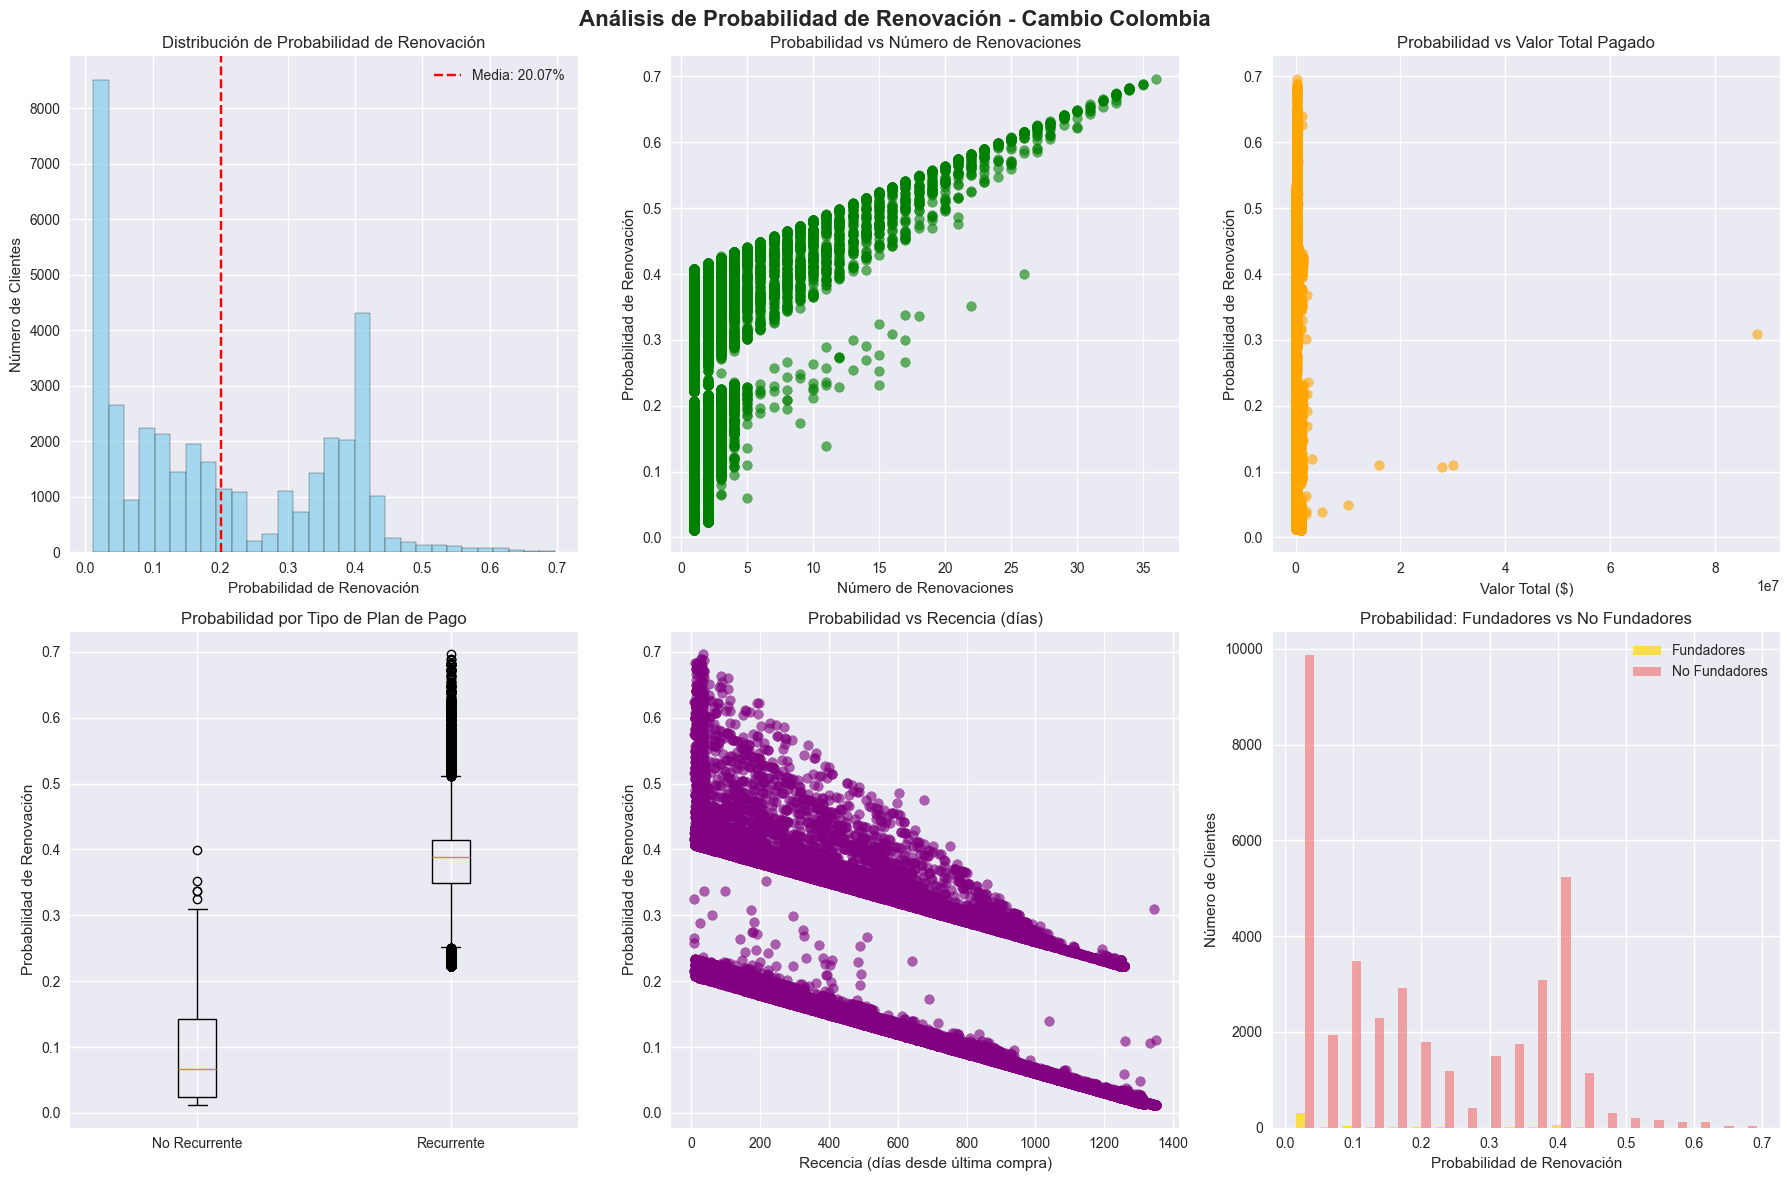

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configurar el estilo de los gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Verificar que tenemos los datos procesados
print(f"Datos cargados: {len(df_grouped)} clientes")
print("Iniciando creación de visualizaciones...")
print("-" * 50)

# ==========================================
# CELDA 3: GRÁFICOS PRINCIPALES (6 gráficos en una sola figura)
# ==========================================

# Crear una figura con múltiples subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis de Probabilidad de Renovación - Cambio Colombia', fontsize=16, fontweight='bold')

# 1. Histograma de Probabilidad de Renovación
axes[0, 0].hist(df_grouped['Probabilidad renovación (%)'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribución de Probabilidad de Renovación')
axes[0, 0].set_xlabel('Probabilidad de Renovación')
axes[0, 0].set_ylabel('Número de Clientes')
axes[0, 0].axvline(df_grouped['Probabilidad renovación (%)'].mean(), color='red', linestyle='--', label=f'Media: {df_grouped["Probabilidad renovación (%)"].mean():.2%}')
axes[0, 0].legend()

# 2. Scatter plot: Probabilidad vs Número de Renovaciones
axes[0, 1].scatter(df_grouped['Numero_renovaciones'], df_grouped['Probabilidad renovación (%)'], alpha=0.6, color='green')
axes[0, 1].set_title('Probabilidad vs Número de Renovaciones')
axes[0, 1].set_xlabel('Número de Renovaciones')
axes[0, 1].set_ylabel('Probabilidad de Renovación')

# 3. Scatter plot: Probabilidad vs Valor Total
axes[0, 2].scatter(df_grouped['Valor_total'], df_grouped['Probabilidad renovación (%)'], alpha=0.6, color='orange')
axes[0, 2].set_title('Probabilidad vs Valor Total Pagado')
axes[0, 2].set_xlabel('Valor Total ($)')
axes[0, 2].set_ylabel('Probabilidad de Renovación')

# 4. Box plot: Probabilidad por Tipo de Plan
axes[1, 0].boxplot([df_grouped[df_grouped['Ultimo_plan_pago'] == 0]['Probabilidad renovación (%)'].values,
                    df_grouped[df_grouped['Ultimo_plan_pago'] == 1]['Probabilidad renovación (%)'].values],
                   labels=['No Recurrente', 'Recurrente'])
axes[1, 0].set_title('Probabilidad por Tipo de Plan de Pago')
axes[1, 0].set_ylabel('Probabilidad de Renovación')

# 5. Scatter plot: Probabilidad vs Recencia
axes[1, 1].scatter(df_grouped['Recencia'], df_grouped['Probabilidad renovación (%)'], alpha=0.6, color='purple')
axes[1, 1].set_title('Probabilidad vs Recencia (días)')
axes[1, 1].set_xlabel('Recencia (días desde última compra)')
axes[1, 1].set_ylabel('Probabilidad de Renovación')

# 6. Histograma comparativo: Fundadores vs No Fundadores
fundadores = df_grouped[df_grouped['Es_Fundador'] == 1]['Probabilidad renovación (%)']
no_fundadores = df_grouped[df_grouped['Es_Fundador'] == 0]['Probabilidad renovación (%)']

axes[1, 2].hist([fundadores, no_fundadores], bins=20, alpha=0.7, 
                label=['Fundadores', 'No Fundadores'], color=['gold', 'lightcoral'])
axes[1, 2].set_title('Probabilidad: Fundadores vs No Fundadores')
axes[1, 2].set_xlabel('Probabilidad de Renovación')
axes[1, 2].set_ylabel('Número de Clientes')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

# Analisis de los 6 gráficos principales:

1. Histograma - Distribución de Probabilidad de Renovación (Superior Izquierda)
- Tipo: Histograma
- Qué muestra: La distribución de frecuencias de las probabilidades de renovación de todos los clientes
- Interpretación: La mayoría de clientes tienen probabilidad baja (0.0-0.2)
Hay un pico muy alto cerca del 0.2 (20%)
La línea roja punteada marca la media (20.07%)
Pocos clientes tienen probabilidad alta (>50%)

2. Scatter Plot - Probabilidad vs Número de Renovaciones (Superior Centro)
- Tipo: Gráfico de dispersión (Scatter Plot)
- Qué muestra: Relación entre cuántas veces ha renovado un cliente y su probabilidad de renovar
- Interpretación: Hay una correlación positiva clara: más renovaciones = mayor probabilidad
Los clientes con 0-5 renovaciones tienen probabilidad baja
Los clientes con 15+ renovaciones tienen alta probabilidad (60-70%)
Es una relación casi lineal

3. Scatter Plot - Probabilidad vs Valor Total Pagado (Superior Derecha)
- Tipo: Gráfico de dispersión (Scatter Plot)
- Qué muestra: Relación entre cuánto ha pagado un cliente y su probabilidad de renovar
- Interpretación: También hay correlación positiva, pero menos clara
Los clientes que han pagado más tienden a tener mayor probabilidad
Hay algunos outliers (clientes que han pagado mucho pero tienen baja probabilidad)

4. Box Plot - Probabilidad por Tipo de Plan de Pago (Inferior Izquierda)
- Tipo: Diagrama de cajas (Box Plot)
- Qué muestra: Comparación de probabilidades entre planes recurrentes vs no recurrentes
- Interpretación: Planes Recurrentes tienen probabilidad mucho mayor (mediana ~40%)
Planes No Recurrentes tienen probabilidad muy baja (mediana ~5%)
La diferencia es dramática - el tipo de plan es muy predictivo

5. Scatter Plot - Probabilidad vs Recencia (Inferior Centro)
- Tipo: Gráfico de dispersión (Scatter Plot)
- Qué muestra: Relación entre días desde última compra y probabilidad de renovar
- Interpretación: Correlación negativa: más días sin comprar = menor probabilidad
Los clientes que compraron recientemente (0-200 días) tienen alta probabilidad
Después de 400+ días, la probabilidad cae dramáticamente
Hay una "caída" clara después de cierto tiempo

6. Histograma Comparativo - Fundadores vs No Fundadores (Inferior Derecha)
- Tipo: Histograma superpuesto
- Qué muestra: Comparación de distribución de probabilidades entre fundadores y no fundadores
- Interpretación: Fundadores (dorado): Tienen distribución más hacia la derecha (mayor probabilidad)
No Fundadores (rosa): Concentrados en probabilidades bajas
Los fundadores son claramente más leales/propensos a renovar

- Insights Clave:
- Variables más predictivas: Plan recurrente > Número de renovaciones > Recencia
- Segmentación natural: Fundadores vs No Fundadores es muy diferenciadora
- Momento crítico: Después de 400 días sin comprar, la probabilidad cae mucho
- Oportunidad: La mayoría de clientes tienen baja probabilidad - hay espacio para mejorar

# 2. MATRIZ DE CORRELACIÓN

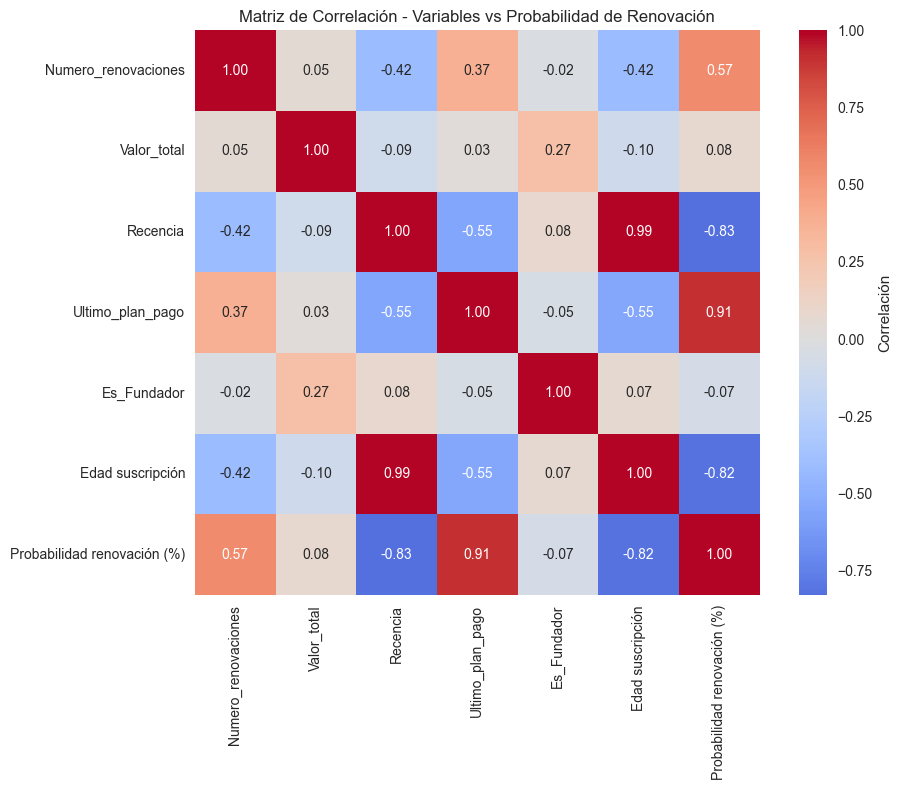

In [25]:
# Crear un gráfico de matriz de correlación
plt.figure(figsize=(10, 8))
correlation_vars = ['Numero_renovaciones', 'Valor_total', 'Recencia', 'Ultimo_plan_pago', 
                   'Es_Fundador', 'Edad suscripción', 'Probabilidad renovación (%)']
correlation_matrix = df_grouped[correlation_vars].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'label': 'Correlación'})
plt.title('Matriz de Correlación - Variables vs Probabilidad de Renovación')
plt.tight_layout()
plt.show()

# Analisis matriz de correlación:

Correlaciones más Significativas con la Probabilidad de Renovación
1. Correlaciones Positivas Fuertes:
- Último plan pago (0.91): Esta es la correlación más fuerte. Los clientes con planes recurrentes tienen una probabilidad de renovación significativamente mayor que aquellos con planes no recurrentes.
- Número de renovaciones (0.57): Correlación moderada-fuerte. Los clientes que han renovado más veces en el pasado tienen mayor probabilidad de renovar nuevamente.

2. Correlaciones Negativas Fuertes:
- Recencia (-0.83): Correlación negativa muy fuerte. Entre más días hayan pasado desde la última compra, menor es la probabilidad de renovación. Esto es crítico para identificar clientes en riesgo.
- Edad de suscripción (-0.82): Correlación negativa fuerte. Los clientes con suscripciones más antiguas tienden a tener menor probabilidad de renovación, posiblemente por fatiga o pérdida de interés.

3. Correlaciones Débiles:
- Valor total (0.08): Correlación muy débil. El monto total pagado históricamente no es un predictor fuerte de renovación.
- Es Fundador (-0.07): Correlación muy débil y ligeramente negativa. Ser cliente fundador no garantiza mayor probabilidad de renovación.

Insights
- Planes recurrentes: Es el factor más predictivo de renovación
- Actuar rápidamente con clientes inactivos: La recencia es crítica
- Cuidar clientes antiguos: Pueden necesitar reactivación


# 3. SEGMENTACIÓN DE CLIENTES

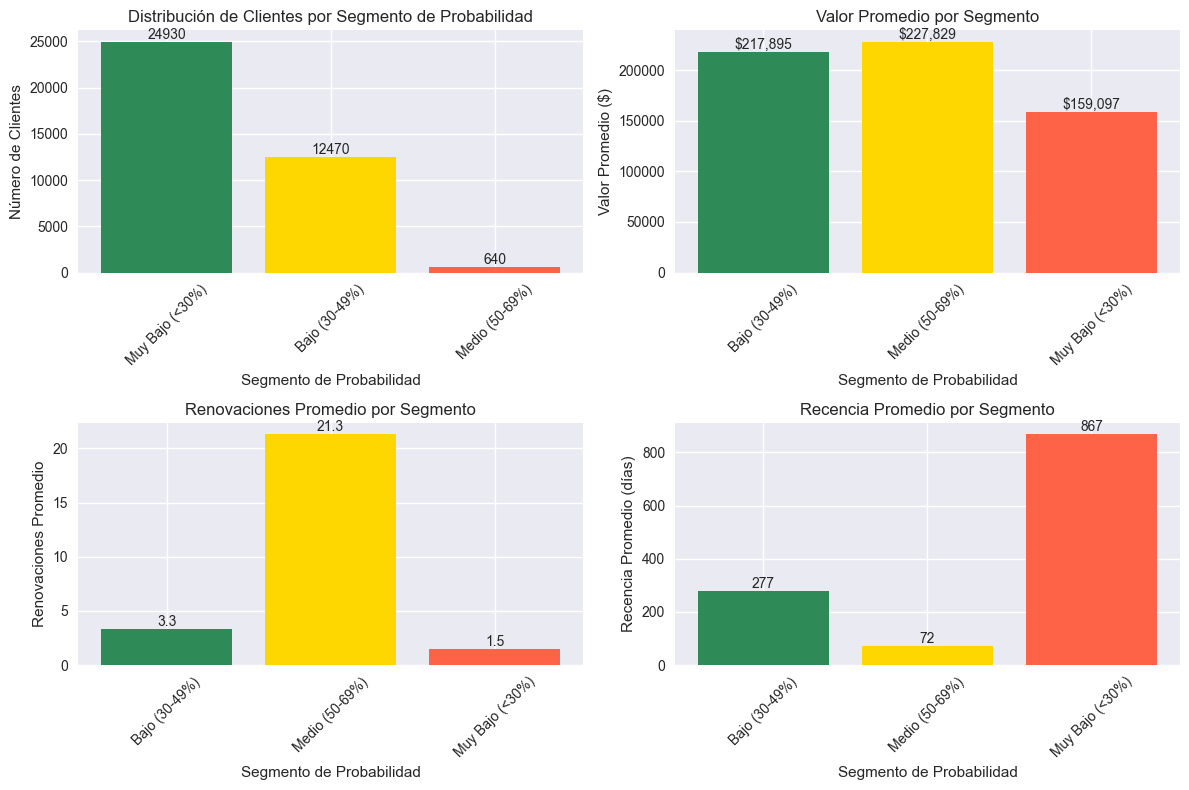

In [26]:
# Crear segmentos basados en probabilidad
def crear_segmento(prob):
    if prob >= 0.7:
        return 'Alto (≥70%)'
    elif prob >= 0.5:
        return 'Medio (50-69%)'
    elif prob >= 0.3:
        return 'Bajo (30-49%)'
    else:
        return 'Muy Bajo (<30%)'

df_grouped['Segmento'] = df_grouped['Probabilidad renovación (%)'].apply(crear_segmento)

# Crear gráfico de segmentación de clientes
plt.figure(figsize=(12, 8))

# Gráfico de barras por segmento
segment_counts = df_grouped['Segmento'].value_counts()
colors = ['#2E8B57', '#FFD700', '#FF6347', '#DC143C']

plt.subplot(2, 2, 1)
bars = plt.bar(segment_counts.index, segment_counts.values, color=colors)
plt.title('Distribución de Clientes por Segmento de Probabilidad')
plt.xlabel('Segmento de Probabilidad')
plt.ylabel('Número de Clientes')
plt.xticks(rotation=45)

# Añadir etiquetas en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

# Valor promedio por segmento
plt.subplot(2, 2, 2)
avg_value_by_segment = df_grouped.groupby('Segmento')['Valor_total'].mean()
bars = plt.bar(avg_value_by_segment.index, avg_value_by_segment.values, color=colors)
plt.title('Valor Promedio por Segmento')
plt.xlabel('Segmento de Probabilidad')
plt.ylabel('Valor Promedio ($)')
plt.xticks(rotation=45)

# Añadir etiquetas en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'${int(height):,}', ha='center', va='bottom')

# Número promedio de renovaciones por segmento
plt.subplot(2, 2, 3)
avg_renewals_by_segment = df_grouped.groupby('Segmento')['Numero_renovaciones'].mean()
bars = plt.bar(avg_renewals_by_segment.index, avg_renewals_by_segment.values, color=colors)
plt.title('Renovaciones Promedio por Segmento')
plt.xlabel('Segmento de Probabilidad')
plt.ylabel('Renovaciones Promedio')
plt.xticks(rotation=45)

# Añadir etiquetas en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}', ha='center', va='bottom')

# Recencia promedio por segmento
plt.subplot(2, 2, 4)
avg_recency_by_segment = df_grouped.groupby('Segmento')['Recencia'].mean()
bars = plt.bar(avg_recency_by_segment.index, avg_recency_by_segment.values, color=colors)
plt.title('Recencia Promedio por Segmento')
plt.xlabel('Segmento de Probabilidad')
plt.ylabel('Recencia Promedio (días)')
plt.xticks(rotation=45)

# Añadir etiquetas en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Analisis segmentación de clientes:

1. Distribución de Clientes (Gráfico Superior Izquierdo)
- Muy Bajo (<30%): 24,930 clientes - La mayoría de tu base (67% aprox.)
- Bajo (30-49%): 12,470 clientes - Segmento medio-grande (33% aprox.)
- Medio (50-69%): 640 clientes - Segmento muy pequeño
- Alto (≥70%): No visible - Prácticamente inexistente
ALERTA CRÍTICA: El 67% de los clientes de CAMBIO tiene probabilidad de renovación menor al 30%. Esto indica una baja retención.

2. Valor Promedio por Segmento (Gráfico Superior Derecho)

- Muy Bajo: $217,895 - Sorprendentemente alto para baja probabilidad
- Medio: $227,829 - El valor más alto
- Bajo: $159,097 - Valor más bajo

3. Renovaciones Promedio por Segmento (Gráfico Inferior Izquierdo)

- Medio: 21.3 renovaciones - Históricamente muy leales
- Muy Bajo: 3.3 renovaciones - Clientes menos experimentados
- Bajo: 1.5 renovaciones - Clientes nuevos o poco comprometidos

INSIGHT: Lasrenovaciones historicas es un predictor fuerte de comportamiento futuro.

4. Recencia Promedio por Segmento (Gráfico Inferior Derecho)

- Muy Bajo: 867 días - Clientes inactivos por casi 2.4 años
- Bajo: 277 días - Inactivos por 9 meses
- Medio: 72 días - Relativamente activos (2.4 meses)

INSIGHT: La recencia confirma la correlación negativa vista en la matriz. Los clientes inactivos son los de mayor riesgo.

- Estrategias Recomendadas por Segmento:
1. Segmento Muy Bajo (24,930 clientes - PRIORIDAD CRÍTICA)
- Campaña de reactivación masiva
- Ofertas especiales para reconexión
- Investigar causas de abandono
- Contenido de valor para re-engagement

2. Segmento Bajo (12,470 clientes)

- Programas de retención proactiva
- Comunicación más frecuente
- Incentivos para aumentar engagement

3. Segmento Medio (640 clientes - PROTEGER)

- Programas VIP
- Atención personalizada
- Beneficios exclusivos (Jorge Caraballo - Reunion con un columnista)

# DASHBOARD - RESUMEN

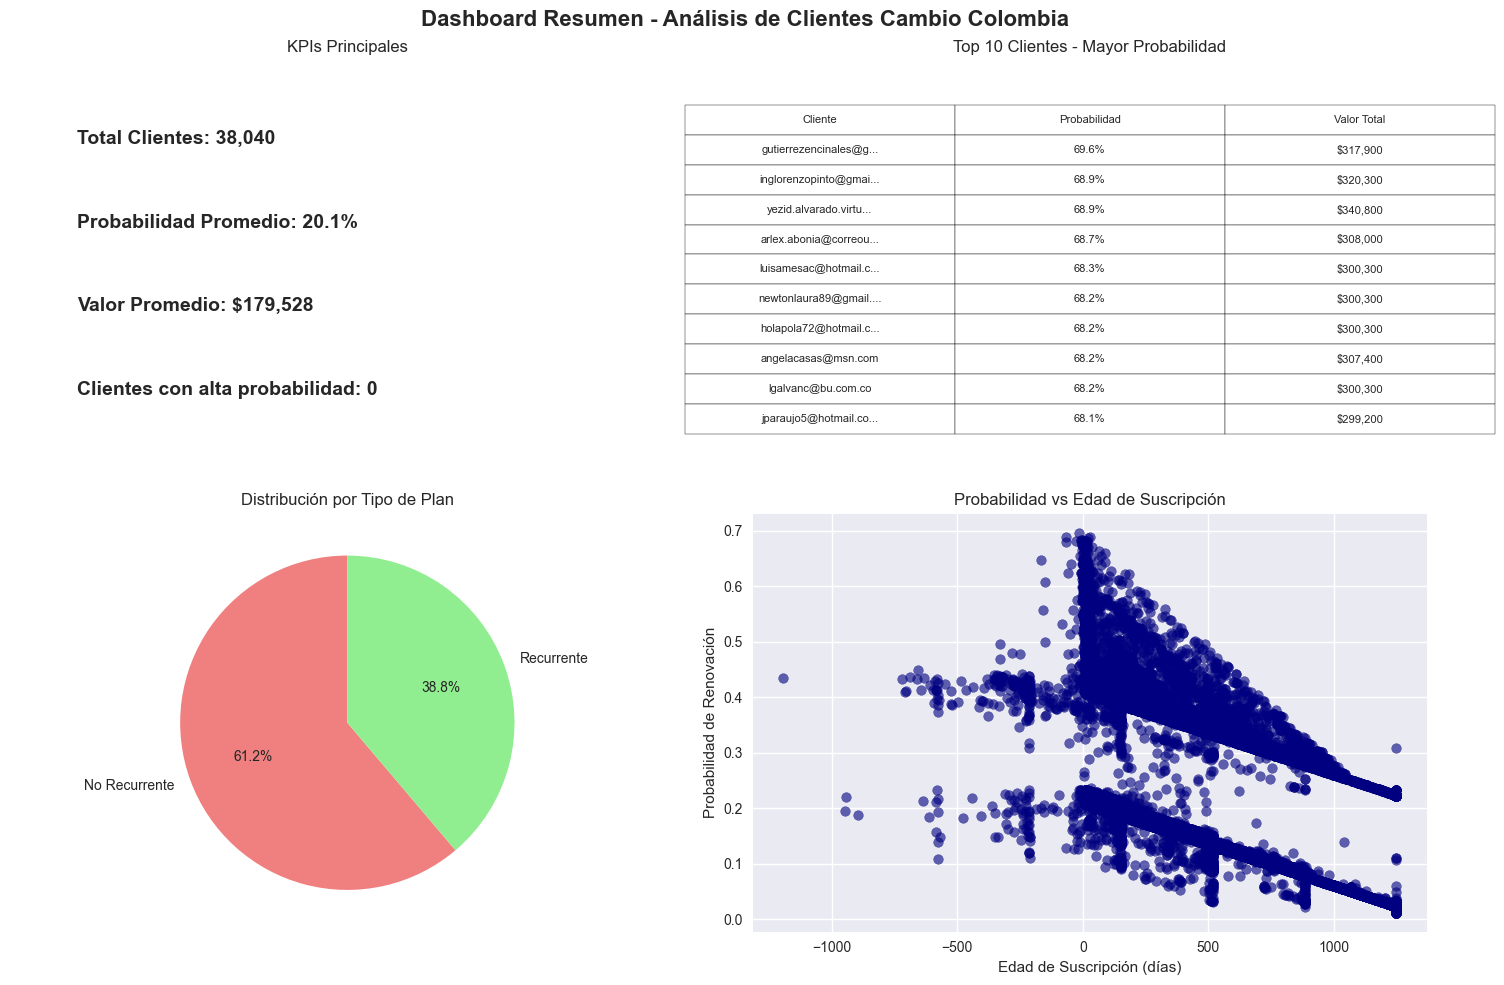

In [27]:
# Crear un dashboard resumen
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Dashboard Resumen - Análisis de Clientes Cambio Colombia', fontsize=16, fontweight='bold')

# KPIs principales
total_clientes = len(df_grouped)
prob_promedio = df_grouped['Probabilidad renovación (%)'].mean()
valor_total_promedio = df_grouped['Valor_total'].mean()
clientes_alto_valor = len(df_grouped[df_grouped['Probabilidad renovación (%)'] >= 0.7])

# Texto con KPIs
axes[0, 0].text(0.1, 0.8, f'Total Clientes: {total_clientes:,}', fontsize=14, fontweight='bold')
axes[0, 0].text(0.1, 0.6, f'Probabilidad Promedio: {prob_promedio:.1%}', fontsize=14, fontweight='bold')
axes[0, 0].text(0.1, 0.4, f'Valor Promedio: ${valor_total_promedio:,.0f}', fontsize=14, fontweight='bold')
axes[0, 0].text(0.1, 0.2, f'Clientes con alta probabilidad: {clientes_alto_valor:,}', fontsize=14, fontweight='bold')
axes[0, 0].set_xlim(0, 1)
axes[0, 0].set_ylim(0, 1)
axes[0, 0].axis('off')
axes[0, 0].set_title('KPIs Principales')

# Top 10 clientes con mayor probabilidad
top_clientes = df_grouped.nlargest(10, 'Probabilidad renovación (%)')[['Correo', 'Probabilidad renovación (%)', 'Valor_total']]
axes[0, 1].axis('tight')
axes[0, 1].axis('off')
table = axes[0, 1].table(cellText=[[row['Correo'][:20] + '...' if len(row['Correo']) > 20 else row['Correo'], 
                                   f"{row['Probabilidad renovación (%)']:.1%}", 
                                   f"${row['Valor_total']:,.0f}"] for _, row in top_clientes.iterrows()],
                        colLabels=['Cliente', 'Probabilidad', 'Valor Total'],
                        cellLoc='center',
                        loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.5)
axes[0, 1].set_title('Top 10 Clientes - Mayor Probabilidad')

# Distribución por tipo de plan
plan_distribution = df_grouped['Ultimo_plan_pago'].value_counts()
labels = ['No Recurrente', 'Recurrente']
colors = ['lightcoral', 'lightgreen']
axes[1, 0].pie(plan_distribution.values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title('Distribución por Tipo de Plan')

# Tendencia de probabilidad vs edad de suscripción
axes[1, 1].scatter(df_grouped['Edad suscripción'], df_grouped['Probabilidad renovación (%)'], alpha=0.6, color='navy')
axes[1, 1].set_title('Probabilidad vs Edad de Suscripción')
axes[1, 1].set_xlabel('Edad de Suscripción (días)')
axes[1, 1].set_ylabel('Probabilidad de Renovación')

plt.tight_layout()
plt.show()

# Analisis Dashboard

Situación Crítica Identificada
KPIs Principales

- Total Clientes: 38,040 - (BD Financiero Cambio Colombia)
- Probabilidad Promedio: 20.1% - CRÍTICO: Solo 1 de cada 5 clientes renovará
- Valor Promedio: $179,528 - Inversión significativa por cliente
- Clientes Alto Riesgo: 0 - NO HAY CLIENTES CON >70% PROBABILIDAD

Top 10 Clientes - Análisis Preocupante

- Máxima probabilidad: 69.6% - Ni siquiera el mejor cliente supera el 70%
- Rango: 68.1% - 69.6% - Muy estrecho, todos en riesgo medio-alto
- Valor promedio top 10: ~$315,000 - Clientes valiosos pero en riesgo

Distribución por Tipo de Plan - Oportunidad Perdida
- No Recurrente: 61.2% - La mayoría no tiene compromiso recurrente
- Recurrente: 38.8% - Minoría con planes automáticos

Probabilidad vs Edad de Suscripción - Tendencia Negativa Clara

El scatter plot revela patrones preocupantes:
- Clientes nuevos (edad negativa): Alta dispersión, algunos con buena probabilidad
- Clientes antiguos (edad positiva): Caída dramática y consistente en probabilidad
- Punto de inflexión: Alrededor de los 0 días (momento de renovación)

Diagnóstico General - Estado CAMBIO COLOMBIA
PROBLEMAS CRÍTICOS:
- Crisis de retención masiva: 80% de clientes con probabilidad <30%
- Ausencia de clientes altamente leales: 0 clientes con >70% probabilidad
- Deterioro por antigüedad: Clientes antiguos abandonan sistemáticamente
- Dependencia de planes no recurrentes: 61% sin compromiso automático

OPORTUNIDADES INMEDIATAS:

- Migración a planes recurrentes: Podría impactar 23,000+ clientes
- Programa de reactivación: Enfocar en los 24,930 clientes de "Muy Bajo"
- Intervención temprana: Actuar antes de que pasen 277 días de inactividad

Recomendaciones Estratégicas para Cambio Colombia:
- Campaña masiva de reactivación para clientes >277 días inactivos
- Ofertas especiales para migrar a planes recurrentes
- Análisis detallado de causas de abandono

# ESTADISTICAS DESCRIPTIVAS

In [28]:
# Imprimir estadísticas descriptivas
print("\n" + "="*50)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("="*50)
print(f"Total de clientes analizados: {total_clientes:,}")
print(f"Probabilidad promedio de renovación: {prob_promedio:.1%}")
print(f"Valor total promedio por cliente: ${valor_total_promedio:,.0f}")
print(f"Clientes con alta probabilidad (≥70%): {clientes_alto_valor:,} ({clientes_alto_valor/total_clientes:.1%})")
print(f"Clientes fundadores: {df_grouped['Es_Fundador'].sum():,} ({df_grouped['Es_Fundador'].mean():.1%})")
print(f"Clientes con plan recurrente: {df_grouped['Ultimo_plan_pago'].sum():,} ({df_grouped['Ultimo_plan_pago'].mean():.1%})")

print("\nDistribución por segmentos:")
for segment, count in segment_counts.items():
    print(f"  {segment}: {count:,} clientes ({count/total_clientes:.1%})")

print("\nRESUMEN DE CORRELACIONES:")
print("-" * 30)
correlations = correlation_matrix['Probabilidad renovación (%)'].sort_values(ascending=False)
for var, corr in correlations.items():
    if var != 'Probabilidad renovación (%)':
        print(f"{var}: {corr:.3f}")


ESTADÍSTICAS DESCRIPTIVAS
Total de clientes analizados: 38,040
Probabilidad promedio de renovación: 20.1%
Valor total promedio por cliente: $179,528
Clientes con alta probabilidad (≥70%): 0 (0.0%)
Clientes fundadores: 493 (1.3%)
Clientes con plan recurrente: 14,761 (38.8%)

Distribución por segmentos:
  Muy Bajo (<30%): 24,930 clientes (65.5%)
  Bajo (30-49%): 12,470 clientes (32.8%)
  Medio (50-69%): 640 clientes (1.7%)

RESUMEN DE CORRELACIONES:
------------------------------
Ultimo_plan_pago: 0.909
Numero_renovaciones: 0.568
Valor_total: 0.075
Es_Fundador: -0.067
Edad suscripción: -0.820
Recencia: -0.829


# EXPORTAR SEGMENTACIÓN

In [29]:
# Exportar el DataFrame con segmentación incluida
archivo_segmentacion = '/Users/juandiegoruizgonzalez/Desktop/Segmentacion_Clientes_Cambio_Colombia.xlsx'

# Crear el archivo con segmentación
with pd.ExcelWriter(archivo_segmentacion, engine='xlsxwriter') as writer:
    df_grouped.to_excel(writer, index=False, sheet_name='Segmentacion')
    
    # Crear hoja de resumen por segmento
    resumen_segmentos = df_grouped.groupby('Segmento').agg({
        'Correo': 'count',
        'Probabilidad renovación (%)': 'mean',
        'Valor_total': 'mean',
        'Numero_renovaciones': 'mean',
        'Recencia': 'mean'
    }).round(2)
    
    resumen_segmentos.to_excel(writer, sheet_name='Resumen_Segmentos')
    
    # Obtener workbook y worksheet
    workbook = writer.book
    worksheet = writer.sheets['Segmentacion']
    
    # Formato de porcentaje
    percent_format = workbook.add_format({'num_format': '0.00%'})
    prob_col = df_grouped.columns.get_loc('Probabilidad renovación (%)')
    worksheet.set_column(prob_col, prob_col, 15, percent_format)

print(f"\nArchivo de segmentación exportado a: {archivo_segmentacion}")


Archivo de segmentación exportado a: /Users/juandiegoruizgonzalez/Desktop/Segmentacion_Clientes_Cambio_Colombia.xlsx


# ---VISUALIZACIONES COMPLETAS---


Datos cargados: 38040 clientes
Iniciando creación de visualizaciones...
--------------------------------------------------


/var/folders/0p/vctscwcd3sjgx6r1h4npy00w0000gn/T/ipykernel_1036/2081864954.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot([df_grouped[df_grouped['Ultimo_plan_pago'] == 0]['Probabilidad renovación (%)'].values,


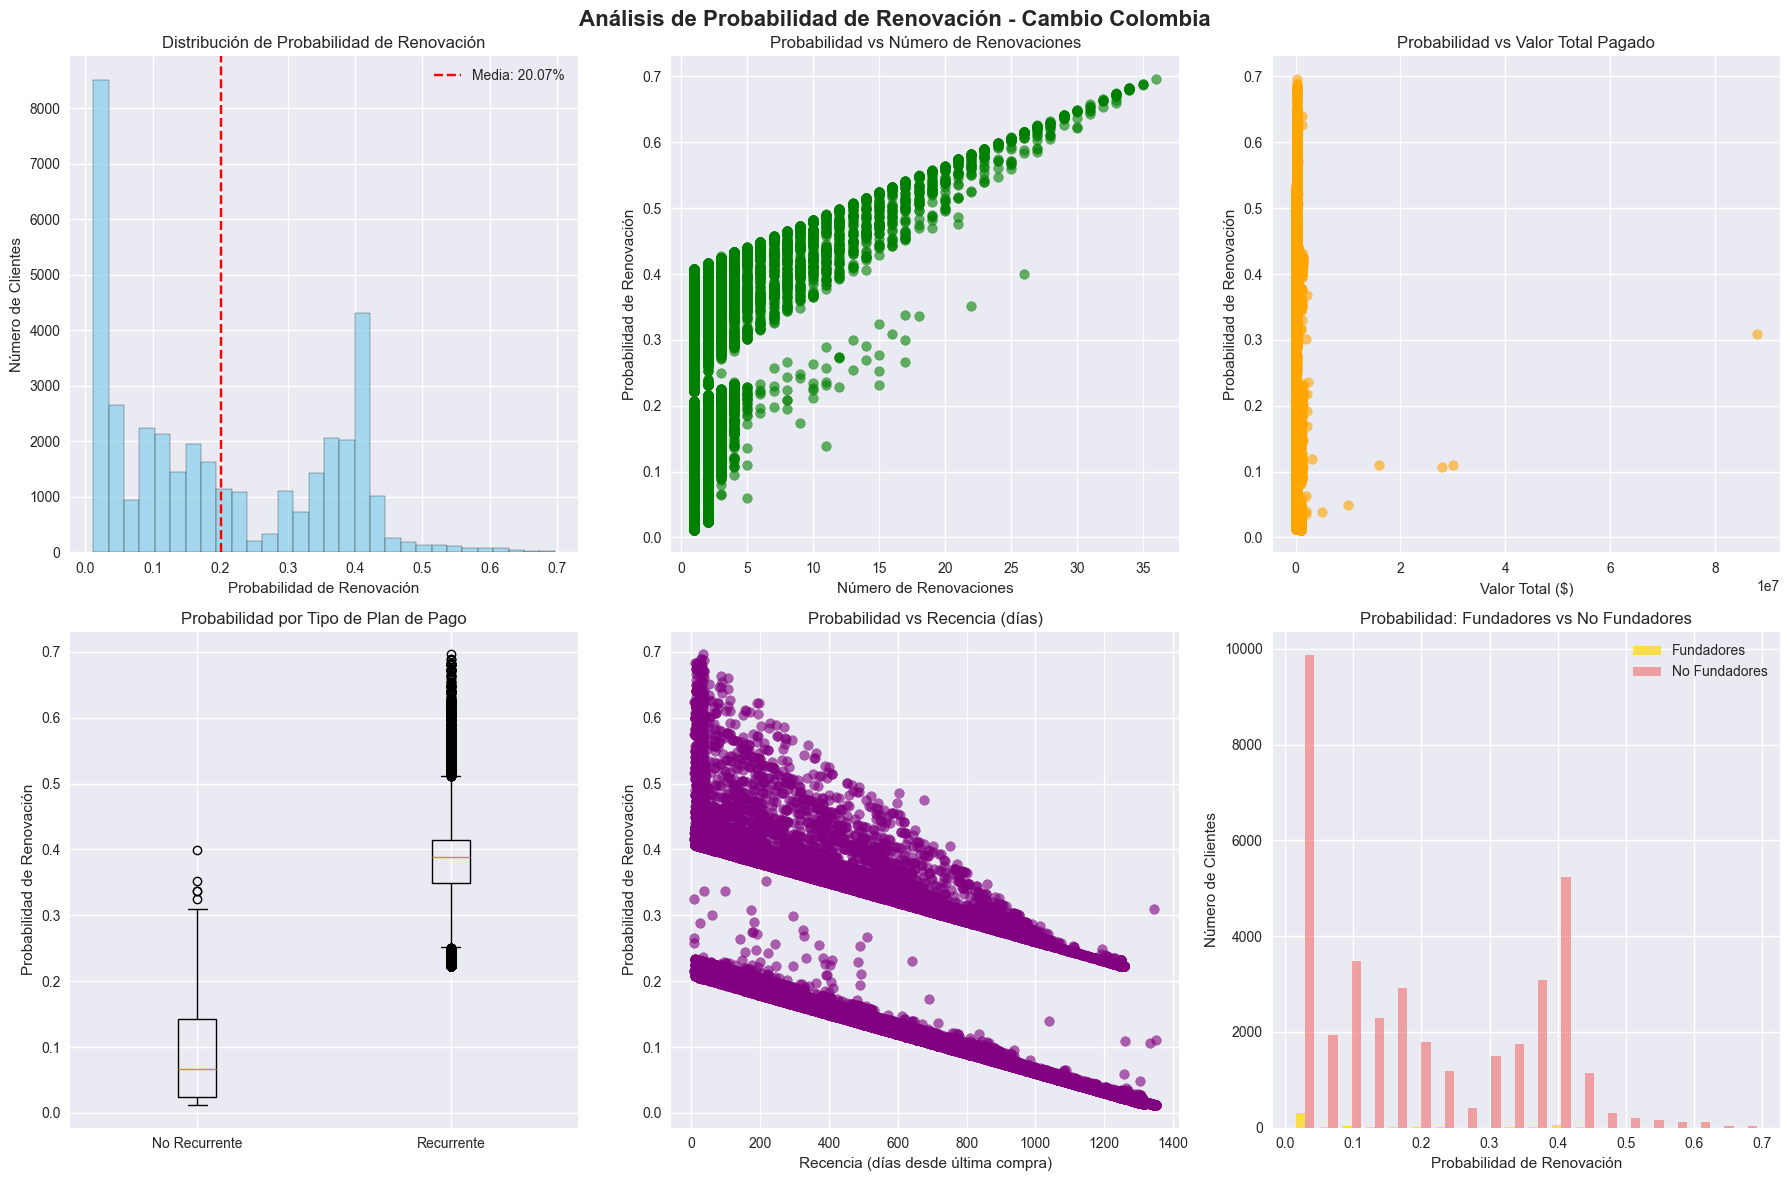

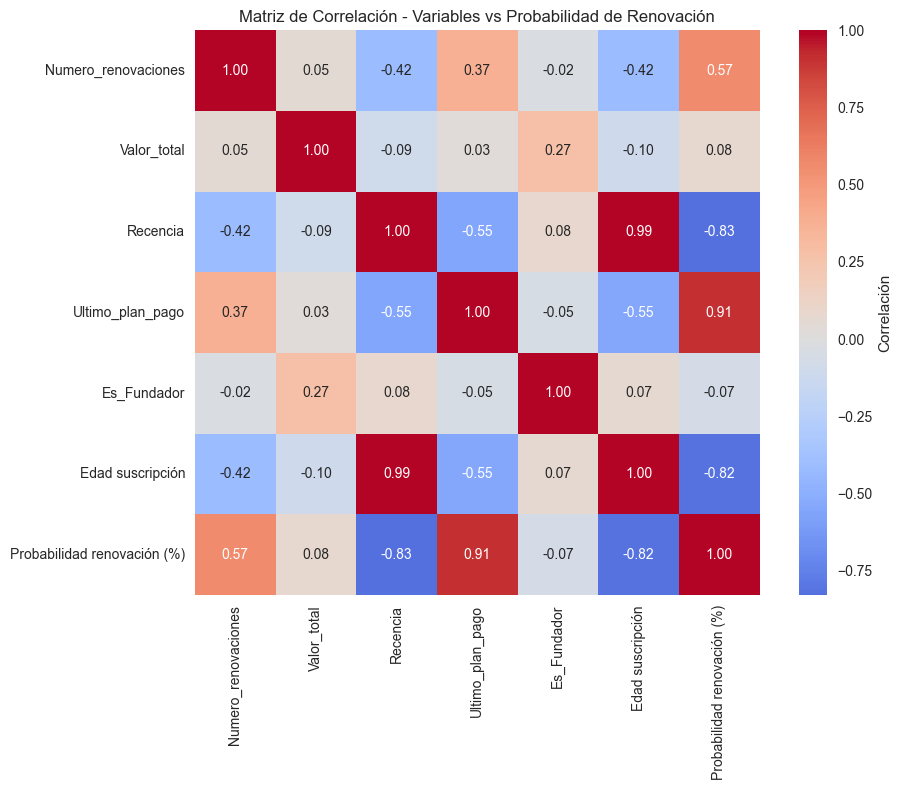

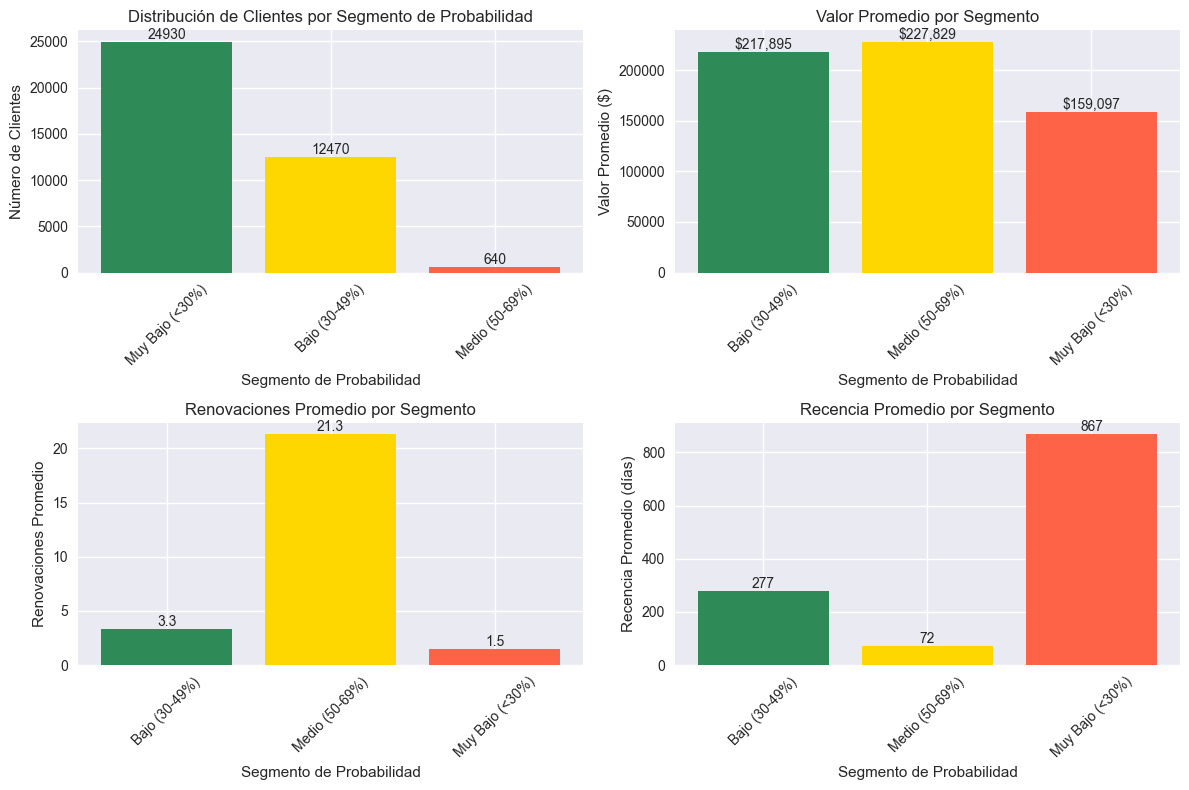

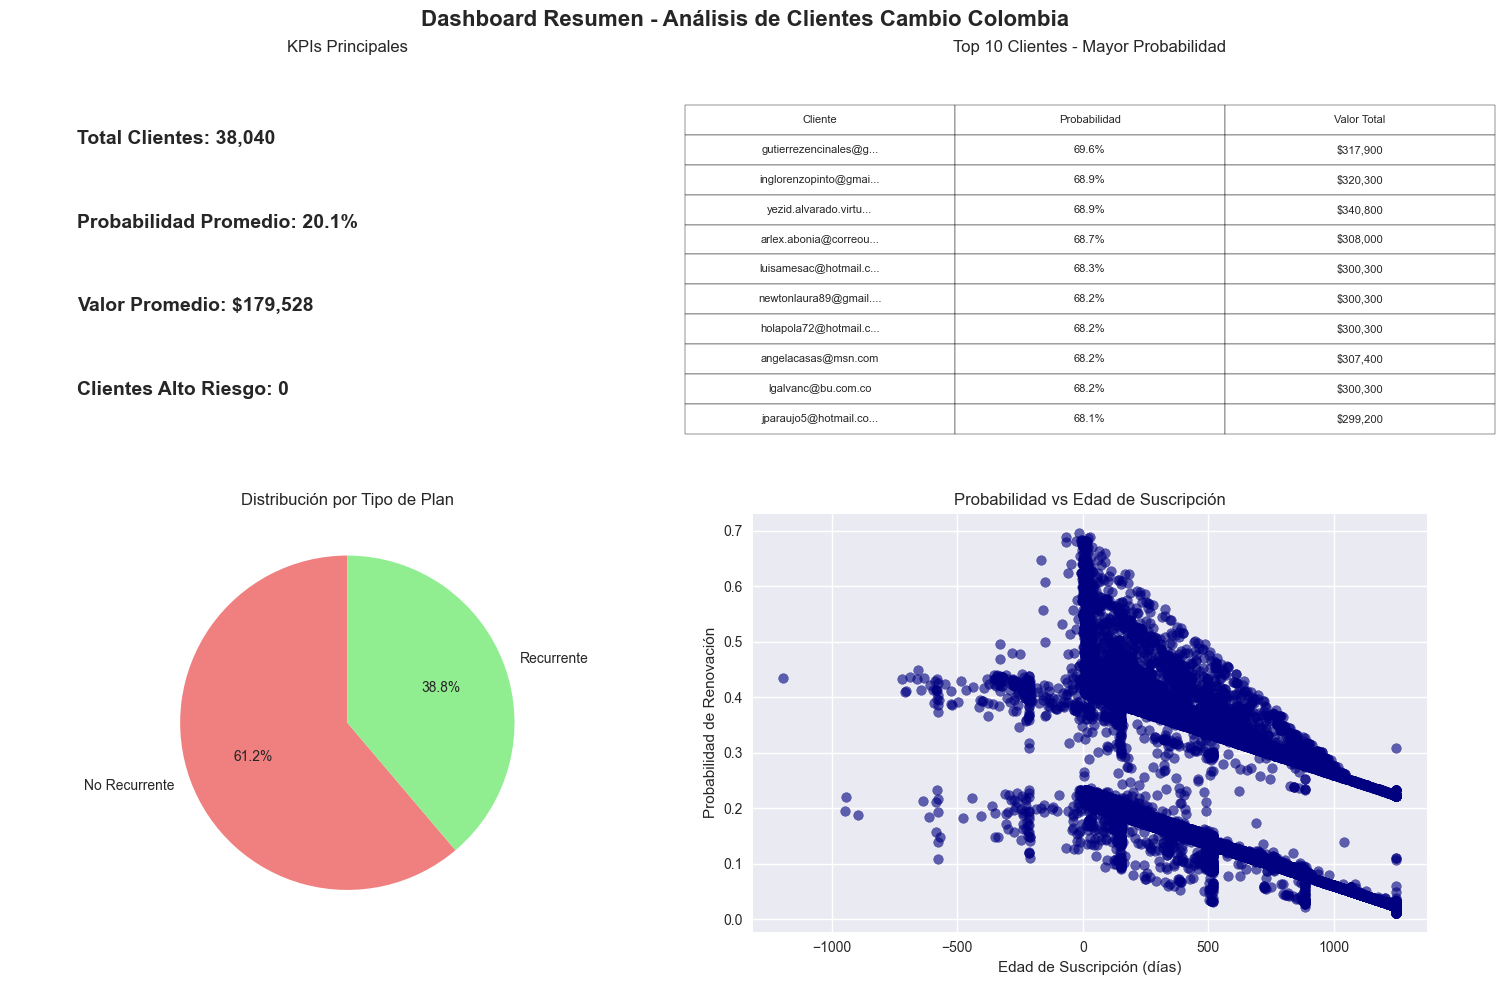


ESTADÍSTICAS DESCRIPTIVAS
Total de clientes analizados: 38,040
Probabilidad promedio de renovación: 20.1%
Valor total promedio por cliente: $179,528
Clientes con alta probabilidad (≥70%): 0 (0.0%)
Clientes fundadores: 493 (1.3%)
Clientes con plan recurrente: 14,761 (38.8%)

Distribución por segmentos:
  Muy Bajo (<30%): 24,930 clientes (65.5%)
  Bajo (30-49%): 12,470 clientes (32.8%)
  Medio (50-69%): 640 clientes (1.7%)


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Configurar el estilo de los gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Verificar que tenemos los datos procesados
print(f"Datos cargados: {len(df_grouped)} clientes")
print("Iniciando creación de visualizaciones...")
print("-" * 50)

# Crear una figura con múltiples subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Análisis de Probabilidad de Renovación - Cambio Colombia', fontsize=16, fontweight='bold')

# 1. Histograma de Probabilidad de Renovación
axes[0, 0].hist(df_grouped['Probabilidad renovación (%)'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribución de Probabilidad de Renovación')
axes[0, 0].set_xlabel('Probabilidad de Renovación')
axes[0, 0].set_ylabel('Número de Clientes')
axes[0, 0].axvline(df_grouped['Probabilidad renovación (%)'].mean(), color='red', linestyle='--', label=f'Media: {df_grouped["Probabilidad renovación (%)"].mean():.2%}')
axes[0, 0].legend()

# 2. Scatter plot: Probabilidad vs Número de Renovaciones
axes[0, 1].scatter(df_grouped['Numero_renovaciones'], df_grouped['Probabilidad renovación (%)'], alpha=0.6, color='green')
axes[0, 1].set_title('Probabilidad vs Número de Renovaciones')
axes[0, 1].set_xlabel('Número de Renovaciones')
axes[0, 1].set_ylabel('Probabilidad de Renovación')

# 3. Scatter plot: Probabilidad vs Valor Total
axes[0, 2].scatter(df_grouped['Valor_total'], df_grouped['Probabilidad renovación (%)'], alpha=0.6, color='orange')
axes[0, 2].set_title('Probabilidad vs Valor Total Pagado')
axes[0, 2].set_xlabel('Valor Total ($)')
axes[0, 2].set_ylabel('Probabilidad de Renovación')

# 4. Box plot: Probabilidad por Tipo de Plan
axes[1, 0].boxplot([df_grouped[df_grouped['Ultimo_plan_pago'] == 0]['Probabilidad renovación (%)'].values,
                    df_grouped[df_grouped['Ultimo_plan_pago'] == 1]['Probabilidad renovación (%)'].values],
                   labels=['No Recurrente', 'Recurrente'])
axes[1, 0].set_title('Probabilidad por Tipo de Plan de Pago')
axes[1, 0].set_ylabel('Probabilidad de Renovación')

# 5. Scatter plot: Probabilidad vs Recencia
axes[1, 1].scatter(df_grouped['Recencia'], df_grouped['Probabilidad renovación (%)'], alpha=0.6, color='purple')
axes[1, 1].set_title('Probabilidad vs Recencia (días)')
axes[1, 1].set_xlabel('Recencia (días desde última compra)')
axes[1, 1].set_ylabel('Probabilidad de Renovación')

# 6. Histograma comparativo: Fundadores vs No Fundadores
fundadores = df_grouped[df_grouped['Es_Fundador'] == 1]['Probabilidad renovación (%)']
no_fundadores = df_grouped[df_grouped['Es_Fundador'] == 0]['Probabilidad renovación (%)']

axes[1, 2].hist([fundadores, no_fundadores], bins=20, alpha=0.7, 
                label=['Fundadores', 'No Fundadores'], color=['gold', 'lightcoral'])
axes[1, 2].set_title('Probabilidad: Fundadores vs No Fundadores')
axes[1, 2].set_xlabel('Probabilidad de Renovación')
axes[1, 2].set_ylabel('Número de Clientes')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

# Crear un gráfico adicional: Matriz de correlación
plt.figure(figsize=(10, 8))
correlation_vars = ['Numero_renovaciones', 'Valor_total', 'Recencia', 'Ultimo_plan_pago', 
                   'Es_Fundador', 'Edad suscripción', 'Probabilidad renovación (%)']
correlation_matrix = df_grouped[correlation_vars].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.2f', cbar_kws={'label': 'Correlación'})
plt.title('Matriz de Correlación - Variables vs Probabilidad de Renovación')
plt.tight_layout()
plt.show()

# Crear un gráfico de segmentación de clientes
plt.figure(figsize=(12, 8))

# Crear segmentos basados en probabilidad
def crear_segmento(prob):
    if prob >= 0.7:
        return 'Alto (≥70%)'
    elif prob >= 0.5:
        return 'Medio (50-69%)'
    elif prob >= 0.3:
        return 'Bajo (30-49%)'
    else:
        return 'Muy Bajo (<30%)'

df_grouped['Segmento'] = df_grouped['Probabilidad renovación (%)'].apply(crear_segmento)

# Gráfico de barras por segmento
segment_counts = df_grouped['Segmento'].value_counts()
colors = ['#2E8B57', '#FFD700', '#FF6347', '#DC143C']

plt.subplot(2, 2, 1)
bars = plt.bar(segment_counts.index, segment_counts.values, color=colors)
plt.title('Distribución de Clientes por Segmento de Probabilidad')
plt.xlabel('Segmento de Probabilidad')
plt.ylabel('Número de Clientes')
plt.xticks(rotation=45)

# Añadir etiquetas en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

# Valor promedio por segmento
plt.subplot(2, 2, 2)
avg_value_by_segment = df_grouped.groupby('Segmento')['Valor_total'].mean()
bars = plt.bar(avg_value_by_segment.index, avg_value_by_segment.values, color=colors)
plt.title('Valor Promedio por Segmento')
plt.xlabel('Segmento de Probabilidad')
plt.ylabel('Valor Promedio ($)')
plt.xticks(rotation=45)

# Añadir etiquetas en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'${int(height):,}', ha='center', va='bottom')

# Número promedio de renovaciones por segmento
plt.subplot(2, 2, 3)
avg_renewals_by_segment = df_grouped.groupby('Segmento')['Numero_renovaciones'].mean()
bars = plt.bar(avg_renewals_by_segment.index, avg_renewals_by_segment.values, color=colors)
plt.title('Renovaciones Promedio por Segmento')
plt.xlabel('Segmento de Probabilidad')
plt.ylabel('Renovaciones Promedio')
plt.xticks(rotation=45)

# Añadir etiquetas en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}', ha='center', va='bottom')

# Recencia promedio por segmento
plt.subplot(2, 2, 4)
avg_recency_by_segment = df_grouped.groupby('Segmento')['Recencia'].mean()
bars = plt.bar(avg_recency_by_segment.index, avg_recency_by_segment.values, color=colors)
plt.title('Recencia Promedio por Segmento')
plt.xlabel('Segmento de Probabilidad')
plt.ylabel('Recencia Promedio (días)')
plt.xticks(rotation=45)

# Añadir etiquetas en las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Crear un dashboard resumen
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Dashboard Resumen - Análisis de Clientes Cambio Colombia', fontsize=16, fontweight='bold')

# KPIs principales
total_clientes = len(df_grouped)
prob_promedio = df_grouped['Probabilidad renovación (%)'].mean()
valor_total_promedio = df_grouped['Valor_total'].mean()
clientes_alto_valor = len(df_grouped[df_grouped['Probabilidad renovación (%)'] >= 0.7])

# Texto con KPIs
axes[0, 0].text(0.1, 0.8, f'Total Clientes: {total_clientes:,}', fontsize=14, fontweight='bold')
axes[0, 0].text(0.1, 0.6, f'Probabilidad Promedio: {prob_promedio:.1%}', fontsize=14, fontweight='bold')
axes[0, 0].text(0.1, 0.4, f'Valor Promedio: ${valor_total_promedio:,.0f}', fontsize=14, fontweight='bold')
axes[0, 0].text(0.1, 0.2, f'Clientes Alto Riesgo: {clientes_alto_valor:,}', fontsize=14, fontweight='bold')
axes[0, 0].set_xlim(0, 1)
axes[0, 0].set_ylim(0, 1)
axes[0, 0].axis('off')
axes[0, 0].set_title('KPIs Principales')

# Top 10 clientes con mayor probabilidad
top_clientes = df_grouped.nlargest(10, 'Probabilidad renovación (%)')[['Correo', 'Probabilidad renovación (%)', 'Valor_total']]
axes[0, 1].axis('tight')
axes[0, 1].axis('off')
table = axes[0, 1].table(cellText=[[row['Correo'][:20] + '...' if len(row['Correo']) > 20 else row['Correo'], 
                                   f"{row['Probabilidad renovación (%)']:.1%}", 
                                   f"${row['Valor_total']:,.0f}"] for _, row in top_clientes.iterrows()],
                        colLabels=['Cliente', 'Probabilidad', 'Valor Total'],
                        cellLoc='center',
                        loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.5)
axes[0, 1].set_title('Top 10 Clientes - Mayor Probabilidad')

# Distribución por tipo de plan
plan_distribution = df_grouped['Ultimo_plan_pago'].value_counts()
labels = ['No Recurrente', 'Recurrente']
colors = ['lightcoral', 'lightgreen']
axes[1, 0].pie(plan_distribution.values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
axes[1, 0].set_title('Distribución por Tipo de Plan')

# Tendencia de probabilidad vs edad de suscripción
axes[1, 1].scatter(df_grouped['Edad suscripción'], df_grouped['Probabilidad renovación (%)'], alpha=0.6, color='navy')
axes[1, 1].set_title('Probabilidad vs Edad de Suscripción')
axes[1, 1].set_xlabel('Edad de Suscripción (días)')
axes[1, 1].set_ylabel('Probabilidad de Renovación')

plt.tight_layout()
plt.show()

# Imprimir estadísticas descriptivas
print("\n" + "="*50)
print("ESTADÍSTICAS DESCRIPTIVAS")
print("="*50)
print(f"Total de clientes analizados: {total_clientes:,}")
print(f"Probabilidad promedio de renovación: {prob_promedio:.1%}")
print(f"Valor total promedio por cliente: ${valor_total_promedio:,.0f}")
print(f"Clientes con alta probabilidad (≥70%): {clientes_alto_valor:,} ({clientes_alto_valor/total_clientes:.1%})")
print(f"Clientes fundadores: {df_grouped['Es_Fundador'].sum():,} ({df_grouped['Es_Fundador'].mean():.1%})")
print(f"Clientes con plan recurrente: {df_grouped['Ultimo_plan_pago'].sum():,} ({df_grouped['Ultimo_plan_pago'].mean():.1%})")

print("\nDistribución por segmentos:")
for segment, count in segment_counts.items():
    print(f"  {segment}: {count:,} clientes ({count/total_clientes:.1%})")